In [5]:
%matplotlib inline

import dill
from collections import defaultdict, Counter
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import digamma,gammaln
import warnings

In [6]:
#read the training files and concatenate them to create the training set

##english
train_e = 'training/hansards.36.2.e'
test_e = 'testing/test/test.e'
dev_e = 'validation/dev.e'
# train_e = 'training/eng.e'

##french
train_f = 'training/hansards.36.2.f'
test_f = 'testing/test/test.f'
dev_f = 'validation/dev.f'
# train_f = 'training/fra.f'

null = ['0NULL']

with open(train_e) as e:
    sentences_e = [null + l.split() for l in e.readlines()]

with open(test_e) as e:
    for l in e.readlines():
         sentences_e.append(null + l.split())

with open(dev_e) as e:
    for l in e.readlines():
         sentences_e.append(null + l.split())

    
with open(train_f) as f:
    sentences_f = [l.split() for l in f.readlines()]

with open(test_f) as f:
    for l in f.readlines():
         sentences_f.append(l.split())

with open(dev_f) as f:
    for l in f.readlines():
         sentences_f.append(l.split())

no_sentences = len(sentences_e)
print(no_sentences)

231648


In [7]:
w2i_e = defaultdict(lambda: len(w2i_e)) #word 2 index english corpus
i2w_e = dict() #index 2 word english corpus
    
w2i_f = defaultdict(lambda: len(w2i_f))  #word 2 index french corpus
i2w_f = dict() #index 2 word french corpus

#here we create w2i and i2w dictionaries for french and english
for i in range (100):
    sent_e = sentences_e[i]
    sent_f = sentences_f[i]
    
    for word_e in sent_e:
        i2w_e[w2i_e[word_e.lower()]] = word_e.lower()
    
    for word_f in sent_f:
        i2w_f[w2i_f[word_f.lower()]] = word_f.lower()

french_vocab = len(w2i_f)
english_vocab = len(w2i_e)

In [9]:
warnings.filterwarnings('error')

this is iteration 0
-184278.71621 -30690.6823417
-214969.398551
this is iteration 1
-177142.500844 -31820.521501
-208963.022345
this is iteration 2
-173969.718066 -29139.0591038
-203108.77717
this is iteration 3
-172562.281979 -25622.5559415
-198184.83792
this is iteration 4
-171837.327148 -23794.9726515
-195632.2998
this is iteration 5
-171471.32116 -22563.3937229
-194034.714883
this is iteration 6
-171407.501381 -21475.5317804
-192883.033162
this is iteration 7
-171566.958686 -20910.6751314
-192477.633817
this is iteration 8
-171756.661018 -20890.7022791
-192647.363297
this is iteration 9
-171927.340286 -20875.8265177
-192803.166804


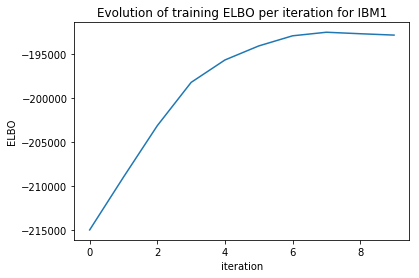

In [12]:
#IBM model 1 with Variational Bayes 
lambda_values_ef = defaultdict(lambda: defaultdict(int))
sum_lambda = defaultdict(int)
thetas = defaultdict(lambda: defaultdict(int))
alpha_value = 0.01
s_total = defaultdict(int)

num_sentences = 100
french_voc = []
english_voc = []

#Here we initialize the thetas (as 0.01) and create lists of the french and english vocabularies

for i in range (num_sentences):
    sent_e = sentences_e[i]
    sent_f = sentences_f[i]
    
    for word_f in sent_f:
        french_voc.append(word_f.lower())
        for word_e in sent_e:
            #initialize the lambda values as alpha (0.01)
            thetas[word_f.lower()][word_e.lower()] = alpha_value
            english_voc.append(word_e.lower())
        

french_voc = list(set(french_voc))
english_voc = list(set(english_voc))

ELBO_list = []
    
num_iterations = 10

#while not converged 
for k in range(num_iterations):
    
    print("this is iteration",k)
    

    lambda_values_ef = defaultdict(lambda: defaultdict(lambda: alpha_value))
    
   
    for sent in range(num_sentences):
        
        sent_e = sentences_e[sent]
        sent_f = sentences_f[sent]
        
        #Here we compute the sum over the lambdas for a french words
        #count for lambdas
        for word_f in sent_f:
            
            s_total[word_f.lower()] = 0
        
            for word_e in sent_e:
        
                s_total[word_f.lower()] += thetas[word_f.lower()][word_e.lower()]
        
        
            for word_e in sent_e:
                    
                delta = thetas[word_f.lower()][word_e.lower()] / s_total[word_f.lower()]
                
                
                lambda_values_ef[word_f.lower()][word_e.lower()] = alpha_value + delta
        
               
                
        for word_e in english_voc:
            
            s_total[word_f.lower()] = 0
            
            for word_f in french_voc:
                
                sum_lambda[word_e.lower()] += lambda_values_ef[word_f.lower()][word_e.lower()]

        #update thetas 
        for word_f in sent_f:
            
            for word_e in sent_e:
                
                thetas[word_f.lower()][word_e.lower()] = np.exp(digamma(lambda_values_ef[word_f.lower()][word_e.lower()]) - digamma(sum_lambda[word_e.lower()]))
               
            
    #Compute the ELBO
    ELBO = 0
    likelihood = 0
    
    #Compute the expected value of the sufficient statistic 
    for sent in range(num_sentences):
        
        sent_e = sentences_e[sent]
        sent_f = sentences_f[sent]
        
        l = len(sent_e) #includes null
        m = len(sent_f)
        
        const = -m * np.log(l)
        
        sent_likelihood = 0 

        for i in range(m):

            word_likelihood = -9999

            best_j = -1 #to be set after the loop below

            for j in range(l):

                temp_likelihood = thetas[sent_f[i].lower()][sent_e[j].lower()]
                
                if word_likelihood == -9999 or temp_likelihood > word_likelihood:

                    word_likelihood = temp_likelihood
                    best_j = j #we can use this part for decoding later
                
            sent_likelihood += np.log(word_likelihood) + const
    
        likelihood += sent_likelihood
    
    #KL-divergence part
    KL = 0
    for e in english_voc:
        
        for f in french_voc:
            
            KL += thetas[f][e] * (alpha_value - lambda_values_ef[f][e]) + gammaln(lambda_values_ef[f][e]) - gammaln(alpha_value)
            
            
        KL += gammaln(alpha_value*len(french_voc))
        
        
        summed_lambdas = 0 
        
        for f in french_voc:
            summed_lambdas += lambda_values_ef[f][e]
        
        KL -= gammaln(summed_lambdas)
    
    print(likelihood, KL)
    ELBO = likelihood + KL
    print(ELBO)
    
    ELBO_list.append(ELBO)

iteration= list(range(len(ELBO_list)))

plt.plot(iteration, ELBO_list)
plt.xlabel("iteration")
plt.ylabel('ELBO')
plt.title('Evolution of training ELBO per iteration for IBM1')
plt.savefig("EM_IBM_VI.png")
plt.show()

In [60]:
#Decoding with IBM model 1 with VBI
#we try to find the most probable alignment given the translation 
#probabilities that were trained with the EM steps
#for each word in a sentence, find highest theta values

def write_naacl(filename):

    naaclfile = open(filename,"w") 

    for sent in range(num_val_sentences):
        sent_e = val_sentences_e[sent]
        sent_f = val_sentences_f[sent]


        l = len(sent_e) #includes null
        m = len(sent_f)

        for f in range(m):
            best_prob = 0
            best_j = 0
            for e in range(l):
                if thetas[sent_f[f].lower()][sent_e[e].lower()] > best_prob:
                    best_prob = thetas[sent_f[f].lower()][sent_e[e].lower()]
                    best_j = e
            if best_j != 0:
                naaclfile.write(str(sent+1) + " " + str(best_j) + " " + str(f+1) + " S" + "\n")
    naaclfile.close()

In [61]:
dev_e = 'validation/dev.e'
test_e = 'testing/test/test.e'
dev_f = 'validation/dev.f'
test_f = 'testing/test/test.f'

with open(test_e) as e:
    val_sentences_e = [null + l.split() for l in e.readlines()]
with open(test_f) as f:
    val_sentences_f = [l.split() for l in f.readlines()]

num_val_sentences = len(val_sentences_e)